In [1]:
%load_ext autoreload
%autoreload 2
import ast
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
from pathlib import Path
from scipy.stats import pearsonr
import seaborn as sb
from preprocessing_sequencing import preprocess_sequences as ps
from matplotlib import rcParams
from final_processing import final_processing_functions as fpf
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from decimal import Decimal
from matplotlib.colors import LogNorm
import itertools
from flexiznam.config import PARAMETERS
import figure_formatting as ff
import yaml
%matplotlib inline

In [2]:
processed_path = Path(PARAMETERS["data_root"]["processed"])
proj_path = processed_path / "turnerb_A1_MAPseq"
with open("general_analysis_parameters.yaml", "r") as file:
    gen_parameters = yaml.safe_load(file)
rcParams['font.sans-serif'] = gen_parameters['font']
rcParams['font.family'] = gen_parameters['font']
rcParams['font.size'] = gen_parameters['font_size']
font_size = gen_parameters['font_size']
saving_path = gen_parameters['fig_saving_path']
mice = gen_parameters['MICE']

In [3]:
allen_comp_dict = {}
to_plot = pd.DataFrame()

for mouse in mice:
    parameters_path = proj_path / mouse / "Sequencing"
    barcodes = pd.read_pickle(
        parameters_path / "A1_barcodes_thresholded_with_source.pkl"
    )
    # select only cortical samples
    parameters = fpf.load_parameters(directory=parameters_path)
    cortical_samples = parameters["cortical_samples"]
    cortical_samples = [
        sample for sample in cortical_samples if sample in barcodes.columns
    ]
    barcodes = barcodes[cortical_samples]
    failed_RT = barcodes.loc[:, (barcodes == 0).all()].columns
    barcodes.drop(columns=failed_RT, inplace=True)
    allen_comp_dict[mouse] = fpf.compare_to_allen(
        barcode_table=barcodes, parameters_path=str(parameters_path)
    )
    temp_df = pd.DataFrame(
        {
            "Allen": np.log10(allen_comp_dict[mouse]["Mean_Allen"] + 1e-3),
            "MAPseq": np.log10(allen_comp_dict[mouse]["MAPseq_counts"] + 1e-3),
            "Mouse": mouse,
            "Allen_expt_A": np.log10(allen_comp_dict[mouse]["Allen_expt_a"] + 1e-3),
            "Allen_expt_B": np.log10(allen_comp_dict[mouse]["Allen_expt_b"] + 1e-3),
            "Allen_expt_C": np.log10(allen_comp_dict[mouse]["Allen_expt_c"] + 1e-3),
        }
    )
    temp_df["Allen_Z_core"] = (temp_df["Allen"] - temp_df["Allen"].mean()) / temp_df[
        "Allen"
    ].std()
    temp_df["MAPseq_Z_score"] = (
        temp_df["MAPseq"] - temp_df["MAPseq"].mean()
    ) / temp_df["MAPseq"].std()
    temp_df["Allen_expt_A_Z_score"] = (
        temp_df["Allen_expt_A"] - temp_df["Allen_expt_A"].mean()
    ) / temp_df["Allen_expt_A"].std()
    temp_df["Allen_expt_B_Z_score"] = (
        temp_df["Allen_expt_B"] - temp_df["Allen_expt_B"].mean()
    ) / temp_df["Allen_expt_B"].std()
    temp_df["Allen_expt_C_Z_score"] = (
        temp_df["Allen_expt_C"] - temp_df["Allen_expt_C"].mean()
    ) / temp_df["Allen_expt_C"].std()
    to_plot = pd.concat([to_plot, temp_df], ignore_index=True)

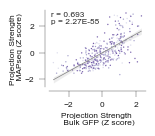

In [4]:
sb.set(style="white")
#sb.set_palette(["#3498DB", "#21618C", "#A9CCE3"]) blues
from seaborn.palettes import color_palette
mouse_ids = to_plot["Mouse"].unique()
purple_palette = color_palette("Purples", len(mouse_ids))
sb.set_palette(purple_palette)

what_plot, ax = plt.subplots(figsize=(1.25, 1))
sb.scatterplot(data=to_plot, x="Allen_Z_core", y="MAPseq_Z_score", hue="Mouse", s=1)
sb.regplot(
    data=to_plot, x="Allen_Z_core", y="MAPseq_Z_score", scatter=False, color="grey", line_kws={'linewidth':0.5}
)
corr, p = pearsonr(to_plot["Allen_Z_core"], to_plot["MAPseq_Z_score"])
x_label = "Projection Strength \n Bulk GFP (Z score)"
y_label = "Projection Strength \n MAPseq (Z score)" 
# leg = plt.legend(loc="upper left", fontsize= font_size, bbox_to_anchor=(0.01, 0.93))
# for h in leg.legendHandles:          # handles are PathCollection objects
#     h.set_sizes([5])  
if ax.get_legend() is not None:
    ax.get_legend().remove()
ax.tick_params(axis='both', which='both', direction='out', length=3, width=0.5, labelsize=font_size)
plt.text(
    0.02,
    0.98,
    f"r = {np.round(corr, 3)}\np = {Decimal(p):.2E}",
    transform=plt.gca().transAxes,
    fontsize=font_size,
    verticalalignment="top",
)
ax.tick_params(axis='both', which='both',
               bottom=True, top=False, left=True, right=False,  
               direction='out', length=4, width=0.6,
               labelsize=font_size)
ff.myPlotSettings_splitAxis(fig=what_plot, ax=ax, ytitle= y_label, xtitle=x_label, title='', mySize =font_size)
plt.show()
what_plot.savefig(f"{saving_path}/fig_1_corr_to_allen.svg", format="svg", bbox_inches='tight')

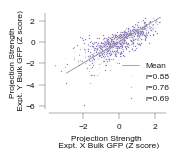

In [5]:
what_plot, ax = plt.subplots(figsize=(1.5, 1.25))

which_expt = ["Allen_expt_A_Z_score", "Allen_expt_B_Z_score", "Allen_expt_C_Z_score"]
expt_name = ["Expt A", "Expt B", "Expt C"]
legend_entries = ['Mean']

for A, B in itertools.combinations([0, 1, 2], 2):
    sb.scatterplot(data=to_plot, x=which_expt[A], y=which_expt[B], marker="X", s=1)
    corr, p = pearsonr(to_plot[which_expt[A]], to_plot[which_expt[B]])
    legend_entries.append(f"r={np.round(corr, 2)}")
sb.regplot(
    data=to_plot, x="Allen_Z_core", y="Allen_Z_core", scatter=False, color="grey", line_kws={'linewidth':0.5}
)
plt.legend(legend_entries, loc="lower right", fontsize=font_size, bbox_to_anchor=(1.1, 0.), frameon=False,)
x_label = "Projection Strength \n Expt. X Bulk GFP (Z score)"
y_label = "Projection Strength \n Expt. Y Bulk GFP (Z score)"
ax.tick_params(axis='both', which='both',
               bottom=True, top=False, left=True, right=False,  
               direction='out', length=4, width=0.6,
               labelsize=font_size)
ff.myPlotSettings_splitAxis(fig=what_plot, ax=ax, ytitle= y_label, xtitle=x_label, title='', mySize =font_size)

plt.show()
what_plot.savefig(f"{saving_path}/supplementary/extended_fig_2_allen_corr.svg", format="svg", bbox_inches='tight')
#blue is a vs b, orange is avs c, green is b vs c

In [48]:
# def combine_broad_regions(dataframe, regions_to_add):
#     summed_data = {}
#     for area, tubes in regions_to_add.items():
#         valid_tubes = [tube for tube in tubes if tube in dataframe.columns]
#         summed_data[area] = dataframe[valid_tubes].sum(axis=1)

#     df_result = pd.DataFrame(summed_data)
#     df_result = df_result.loc[(df_result != 0).any(axis=1)]
#     return df_result

In [6]:
samples_to_combine = {}
mean_umi_tab = pd.DataFrame()
for i, mouse in enumerate(mice):
    which_samples = {}
    parameters_path = proj_path / mouse / "Sequencing"
    # Load the barcode data for the current mouse
    barcodes = pd.read_pickle(parameters_path / "A1_barcodes_thresholded.pkl")
    failed_RT = barcodes.loc[:, (barcodes == 0).all()].columns
    barcodes.drop(columns=failed_RT, inplace=True)
    parameters = ps.load_parameters(directory=parameters_path)
    # which_samples['Pons'] = parameters['pons_samples']
    which_samples["Ipsi Cortex"] = [
        sample
        for sample in parameters["cortical_samples"]
        if sample not in parameters["contra"]
    ]
    which_samples["Contra Cortex"] = parameters["contra"]
    which_samples["Striatum"] = parameters["striatum_samples"]
    which_samples["Tectum"] = parameters["tectum_samples"]
    which_samples["Thalamus"] = parameters["thalamus_samples"]
    which_samples["IC"] = parameters["IC_samples"]
    which_samples["SC"] = parameters["SC_samples"]
    table_to_look = ff.combine_broad_regions(
        dataframe=barcodes, regions_to_add=which_samples
    )
    mean_umi_dict = {}
    for key in which_samples.keys():
        samples = [
            sample for sample in which_samples[key] if sample in barcodes.columns
        ]
        selection = barcodes[barcodes[samples].astype(bool).sum(axis=1) > 0][
            samples
        ].melt()
        values = [val for val in selection["value"] if val > 0]
        mean_umi_dict[key] = np.mean(values)
    mean_umi_dict["mouse"] = mouse
    mean_umi_tab = mean_umi_tab.append(mean_umi_dict, ignore_index=True)
    if i == 0:
        combined_table = table_to_look
    else:
        combined_table = pd.concat([combined_table, table_to_look])

In [7]:
striatum_projecting = combined_table[combined_table["Striatum"] > 0]
PT_num = len(
    striatum_projecting[
        striatum_projecting[["Tectum", "Thalamus"]].astype(bool).astype(int).sum(axis=1)
        > 0
    ]
)
contra_num = len(
    striatum_projecting[
        striatum_projecting[["Contra Cortex"]].astype(bool).astype(int).sum(axis=1) > 0
    ]
)
overlapping_num = len(
    striatum_projecting[
        (
            striatum_projecting[["Tectum", "Thalamus"]]
            .astype(bool)
            .astype(int)
            .sum(axis=1)
            > 0
        )
        & (striatum_projecting["Contra Cortex"].astype(bool).astype(int) > 0)
    ]
)
wrong_thal = len(
    striatum_projecting[
        (striatum_projecting["Thalamus"].astype(bool).astype(int) > 0)
        & (striatum_projecting["Tectum"].astype(bool).astype(int) == 0)
    ]
)
print(
    f"number PT = {PT_num}, number contra IT = {contra_num}, number overlapping = {overlapping_num}, thal_not_tect= {wrong_thal}, tot_striatum = {len(striatum_projecting)}"
)

number PT = 285, number contra IT = 689, number overlapping = 3, thal_not_tect= 32, tot_striatum = 1624


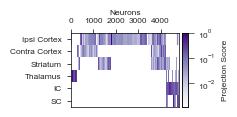

In [8]:
sb.set(font_scale=1, style="white")
areas_to_look = [
    "Ipsi Cortex",
    "Contra Cortex",
    "Striatum",
    "IC",
    "SC",
    "Thalamus",
]
combined_table_to_look = combined_table[areas_to_look]
cluster = sb.clustermap(
    combined_table_to_look.T,
    metric="canberra",
    row_cluster=True,
    standard_scale=0,
    norm=LogNorm(),
    cmap="Purples",
    figsize=(2.8, 1.5),
    xticklabels=False,
    yticklabels=True,
    cbar_pos=(0.8, 0.12, 0.02, 0.65),
    cbar_kws={"label": "Normalised \n projection strength"},
)
cluster.ax_row_dendrogram.set_visible(False)
cluster.ax_col_dendrogram.set_visible(False)
cluster.ax_heatmap.yaxis.set_ticks_position("left")
cluster.ax_heatmap.yaxis.set_label_position("left")
cluster.ax_heatmap.set_xlabel("")  

for spine in cluster.ax_heatmap.spines.values():
    spine.set_visible(True)  
    spine.set_linewidth(0.5) 
    spine.set_color("black")  
for spine in cluster.cax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(0.5)  
    spine.set_color("black")
cluster.cax.set_ylabel("Projection Score", fontsize=font_size)

cluster.fig.canvas.draw_idle()         
cb_width = 0.02                     
gap      = 0.01   
heat_pos = cluster.ax_heatmap.get_position()         
cluster.cax.set_position([
    heat_pos.x1 + gap,                
    heat_pos.y0,                      
    cb_width,                         
    heat_pos.height,                   
])
cluster.cax.tick_params(
    axis='y',      
    which='both',
    labelsize=font_size,
    length=4,       
    width=0.5          
)
heat_pos = cluster.ax_heatmap.get_position() 
num_barcodes = len(combined_table)
tick_positions = range(0, num_barcodes, 1000)
tick_labels = [str(pos) for pos in tick_positions]
cluster.ax_heatmap.set_xticks(tick_positions)
cluster.ax_heatmap.set_xticklabels(tick_labels, rotation=0)
cluster.ax_heatmap.tick_params(
    which="both", length=3, color="black", width =0.5
)  
cluster.ax_heatmap.tick_params(axis="y", which="major", labelsize=font_size)
cluster.ax_heatmap.tick_params(axis="x", which="major", labelsize=font_size)
cluster.ax_heatmap.xaxis.set_ticks_position("top") 
cluster.ax_heatmap.xaxis.set_label_position("top")
cluster.ax_heatmap.set_xlabel("Neurons", fontsize=font_size, labelpad=2.5)
cluster.cax.yaxis.set_minor_locator(plt.NullLocator())
plt.show()
cluster.savefig(f"{saving_path}/fig_1_clustermap.svg", format="svg", bbox_inches='tight')

In [9]:
IT = {}
PT = {}
CT = {}
layers = ["upper", "lower"]
for num, mouse in enumerate(mice):
    new_dict = {}
    parameters_path = proj_path / mouse / "Sequencing"
    barcodes = pd.read_pickle(
        parameters_path / "A1_barcodes_thresholded_with_source.pkl"
    )
    parameters = ps.load_parameters(directory=parameters_path)
    sample_vol_and_regions = pd.read_pickle(
        processed_path
        / ("turnerb_" + parameters["lcm_directory"].split("turnerb_")[1])
        / "sample_vol_and_regions.pkl"
    )
    sample_vol_and_regions["fractions"] = sample_vol_and_regions["breakdown"].apply(
        ast.literal_eval
    )
    sample_vol_and_regions["regions"] = sample_vol_and_regions["regions"].apply(
        ast.literal_eval
    )
    AUDp_containing = sample_vol_and_regions[sample_vol_and_regions["main"] == "AUDp"][
        "ROI Number"
    ].to_list()
    AUDp_containing = [
        sample for sample in AUDp_containing if sample in barcodes.columns
    ]
    for layer in layers:
        if num == 0:
            IT[layer] = []
            CT[layer] = []
            PT[layer] = []
        new_dict[f"{layer}_layer"] = barcodes[
            barcodes.idxmax(axis=1).isin(parameters[f"{layer}_layer"])
        ].drop(columns=AUDp_containing)
        IT[layer].append(
            len(
                new_dict[f"{layer}_layer"][
                    (
                        new_dict[f"{layer}_layer"][
                            [
                                f
                                for f in parameters["cortical_samples"]
                                if f in new_dict[f"{layer}_layer"].columns
                            ]
                        ]
                        .astype(bool)
                        .sum(axis=1)
                        > 0
                    )
                    & (
                        new_dict[f"{layer}_layer"][
                            [
                                s
                                for s in parameters["tectum_samples"]
                                if s in new_dict[f"{layer}_layer"].columns
                            ]
                        ]
                        .astype(bool)
                        .sum(axis=1)
                        == 0
                    )
                    & (
                        new_dict[f"{layer}_layer"][
                            [
                                s
                                for s in parameters["thalamus_samples"]
                                if s in new_dict[f"{layer}_layer"].columns
                            ]
                        ]
                        .astype(bool)
                        .sum(axis=1)
                        == 0
                    )
                ]
            )
        )
        PT[layer].append(
            len(
                new_dict[f"{layer}_layer"][
                    new_dict[f"{layer}_layer"][
                        [
                            f
                            for f in parameters["tectum_samples"]
                            if f in new_dict[f"{layer}_layer"].columns
                        ]
                    ]
                    .astype(bool)
                    .sum(axis=1)
                    > 0
                ]
            )
        )
        CT[layer].append(
            len(
                new_dict[f"{layer}_layer"][
                    (
                        new_dict[f"{layer}_layer"][
                            [
                                s
                                for s in parameters["tectum_samples"]
                                if s in new_dict[f"{layer}_layer"].columns
                            ]
                        ]
                        .astype(bool)
                        .sum(axis=1)
                        == 0
                    )
                    & (
                        new_dict[f"{layer}_layer"][
                            [
                                s
                                for s in parameters["thalamus_samples"]
                                if s in new_dict[f"{layer}_layer"].columns
                            ]
                        ]
                        .astype(bool)
                        .sum(axis=1)
                        > 0
                    )
                ]
            )
        )

tot_IT_upper = np.sum(IT["upper"])
tot_IT_lower = np.sum(IT["lower"])
tot_PT_upper = np.sum(PT["upper"])
tot_CT_upper = np.sum(CT["upper"])
tot_PT_lower = np.sum(PT["lower"])
tot_CT_lower = np.sum(CT["lower"])

In [29]:
# layers = ["Upper Layer", "Deep Layer"]
# IT_neurons = [tot_IT_upper, tot_IT_lower]
# PT_neurons = [tot_PT_upper, tot_PT_lower]
# CT_neurons = [tot_CT_upper, tot_CT_lower]

# fig, ax = plt.subplots(figsize=(0.55, 1))

# bar_width = 0.7
# ax.bar(layers, IT_neurons, label="IT", color="steelblue", width=bar_width)
# ax.bar(
#     layers,
#     PT_neurons,
#     bottom=IT_neurons,
#     label="PT",
#     color="skyblue",
#     width=bar_width,
# )
# ax.bar(
#     layers,
#     CT_neurons,
#     bottom=[i + j for i, j in zip(IT_neurons, PT_neurons)],
#     label="CT",
#     color="orchid",
#     width=bar_width,
# )
# ax.tick_params(axis='both', which='both',
#                bottom=True, top=False, left=True, right=False,  
#                direction='out', length=4, width=0.6,
#                labelsize=font_size)
# ax.set_xticklabels(['Upper', 'Lower'], fontsize=font_size)
# ax.tick_params(axis="both", labelsize=font_size)
# y_label= "Number of Neurons"
# ax.legend(loc="lower right", fontsize=font_size, bbox_to_anchor=(2.2, 0.55))

# ff.myPlotSettings_splitAxis(fig=fig, ax=ax, ytitle=y_label, xtitle='Layers', title='', mySize=font_size)
# plt.show()
# fig.savefig(f"{saving_path}/fig_1_uppervsdeep_layers.svg", format="svg")

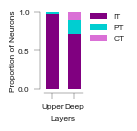

In [10]:
total_upper = tot_IT_upper + tot_PT_upper + tot_CT_upper
total_lower = tot_IT_lower + tot_PT_lower + tot_CT_lower

IT_neurons = [tot_IT_upper / total_upper, tot_IT_lower / total_lower]
PT_neurons = [tot_PT_upper / total_upper, tot_PT_lower / total_lower]
CT_neurons = [tot_CT_upper / total_upper, tot_CT_lower / total_lower]

layers = ["Upper", "Deep"]

fig, ax = plt.subplots(figsize=(0.5, 1))

bar_width = 0.6
ax.bar(layers, IT_neurons, label="IT", color="purple", width=bar_width, edgecolor='none')
ax.bar(
    layers,
    PT_neurons,
    bottom=IT_neurons,
    label="PT",
    color="darkturquoise",
    width=bar_width, edgecolor='none',
)
ax.bar(
    layers,
    CT_neurons,
    bottom=[i + j for i, j in zip(IT_neurons, PT_neurons)],
    label="CT",
    color="orchid",
    width=bar_width, edgecolor='none',
)
ax.tick_params(axis='both', which='both',
               bottom=True, top=False, left=True, right=False,  
               direction='out', length=4, width=0.6,
               labelsize=font_size)

ax.set_ylabel("Proportion of Neurons", size=font_size)
ax.set_yticks([0, 0.5, 1])
ax.tick_params(axis="both", labelsize=font_size)

ax.legend(loc="center left", bbox_to_anchor=(1, 0.8), frameon=False, fontsize=font_size)
ff.myPlotSettings_splitAxis(fig=fig, ax=ax, ytitle='Proportion of Neurons', xtitle='Layers', title='', mySize=font_size)
plt.show()
fig.savefig(f"{saving_path}/fig_1_uppervsdeep_layers.svg", format="svg")

Plot correlations between mice

In [11]:
# mice = ["FIAA45.6a", "FIAA45.6d", "FIAA55.4d"]
combined_mice_dict = {}
for mouse in mice:
    new_dict = {}
    parameters_path = proj_path / mouse / "Sequencing"
    barcodes = pd.read_pickle(parameters_path / "A1_barcodes_thresholded.pkl")
    failed_RT = barcodes.loc[:, (barcodes == 0).all()].columns
    barcodes.drop(columns=failed_RT, inplace=True)
    # normalise barcodes to total sum
    parameters = ps.load_parameters(directory=parameters_path)
    processed_path = Path(PARAMETERS["data_root"]["processed"])
    lcm_directory = processed_path / (
        "turnerb_" + parameters["lcm_directory"].split("turnerb_")[1]
    )
    new_dict["homog_across_cubelet"] = fpf.homog_across_cubelet(
        parameters_path=parameters_path,
        barcode_matrix=barcodes,
        cortical=True,
        shuffled=False,
    )
    new_dict["area_is_main"] = fpf.area_is_main(
        parameters_path=parameters_path,
        barcode_matrix=barcodes,
        cortical=True,
        shuffled=False,
    )
    new_dict["homog_across_area"] = fpf.homog_across_area(
        parameters_path=parameters_path,
        barcode_matrix=barcodes,
        cortical=True,
        shuffled=False,
    )
    new_dict["all_areas"] = fpf.get_area_volumes(
        barcode_table_cols=barcodes.columns, lcm_directory=lcm_directory
    )

    combined_mice_dict[mouse] = new_dict

In [12]:
analysis_list = ["homog_across_cubelet", "homog_across_area", "area_is_main"]
corr_dict = {}
mcc = MouseConnectivityCache()
structure_tree = mcc.get_structure_tree()
rsp = mcc.get_reference_space()
for key in analysis_list:
    correlation_matrix = pd.DataFrame(columns=mice, index=mice)
    for mouse_1 in mice:
        for mouse_2 in mice:
            if mouse_1 == mouse_2:
                correlation_matrix.loc[mouse_1, mouse_2] = np.nan
            else:
                common_columns = set(
                    combined_mice_dict[mouse_1][key].columns
                ).intersection(combined_mice_dict[mouse_2][key].columns)
                common_cols_cortex = []
                for col in common_columns:
                    if col != "Contra":
                        structure = structure_tree.get_structures_by_acronym([col])
                        if 315 in structure[0]["structure_id_path"]:
                            common_cols_cortex.append(col)
                    if col == "Contra":
                        common_cols_cortex.append(col)
                mean_A = np.log10(
                    combined_mice_dict[mouse_1][key][common_cols_cortex].mean(axis=0)
                    + 1e-10
                )
                mean_B = np.log10(
                    combined_mice_dict[mouse_2][key][common_cols_cortex].mean(axis=0)
                    + 1e-10
                )
                corr, p = pearsonr(mean_A, mean_B)
                correlation_matrix.loc[mouse_1, mouse_2] = corr
                correlation_matrix = correlation_matrix.apply(
                    pd.to_numeric, errors="coerce"
                )

    corr_dict[key] = correlation_matrix

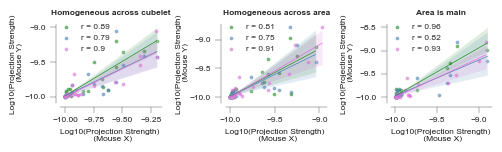

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(5, 1.5))
analysis_list = ["homog_across_cubelet", "homog_across_area", "area_is_main"]
corr_dict = {}
mcc = MouseConnectivityCache()
structure_tree = mcc.get_structure_tree()
rsp = mcc.get_reference_space()
color_list = ["forestgreen", "steelblue", "orchid"]
titles = ["Homogeneous across cubelet", "Homogeneous across area", "Area is main"]
x_label = "Log10(Projection Strength) \n (Mouse X)"
y_label="Log10(Projection Strength) \n (Mouse Y)"
for i, key in enumerate(analysis_list):
    # correlation_matrix = pd.DataFrame(columns=mice, index=mice)
    ax = axes[i]
    x = 0
    for mouse_1, mouse_2 in itertools.combinations(mice, 2):
        common_columns = set(combined_mice_dict[mouse_1][key].columns).intersection(
            combined_mice_dict[mouse_2][key].columns
        )
        common_cols_cortex = []
        for col in common_columns:
            if col != "Contra":
                structure = structure_tree.get_structures_by_acronym([col])
                if 315 in structure[0]["structure_id_path"]:
                    common_cols_cortex.append(col)
            if col == "Contra":
                common_cols_cortex.append(col)
        mean_A = np.log10(
            combined_mice_dict[mouse_1][key][common_cols_cortex].mean(axis=0) + 1e-10
        )
        mean_B = np.log10(
            combined_mice_dict[mouse_2][key][common_cols_cortex].mean(axis=0) + 1e-10
        )
        corr, p = pearsonr(mean_A, mean_B)
        # sb.scatterplot(x=mean_A, y=mean_B, ax=ax, s=20, color='#3498DB', label='Data points')
        # sb.regplot(x=mean_A, y=mean_B, ax=ax, scatter=True, label=f'{mouse_1} vs {mouse_2} \n r = {corr}')
        sb.regplot(
            x=mean_A,
            y=mean_B,
            ax=ax,
            scatter=True,
            label=f"r = {np.round(corr, 2)}",
            scatter_kws={
        "color": color_list[x],
        "s": 3, "alpha":0.5
    },
    line_kws={
        "color": color_list[x],
        "linewidth": 0.5  # thinner regression line
    },
        )
        x = x + 1
   
    ax.tick_params(axis='both', which='both',
               bottom=True, top=False, left=True, right=False,  
               direction='out', length=4, width=0.6,
               labelsize=font_size)
    ax.legend(loc="upper left", fontsize=font_size, frameon=False, bbox_to_anchor=(-0.1, 1.1))
    ff.myPlotSettings_splitAxis(fig=fig, ax=ax, ytitle=y_label, xtitle=x_label, title=titles[i], mySize=font_size)
#plt.subplots_adjust(left=0.05, right=0.9, wspace=0.3)
                      # make sure artists are up‑to‑date
plt.tight_layout()
plt.show()
fig.savefig(f"{saving_path}/supplementary/extended_data_fig_2_cross_mouse_corr.svg", format="svg")
#green is mouse FIAA45.6a vs FIAA45.6d, blue = FIAA45.6a vs FIAA55.4d, pink=FIAA45.6d vs FIAA55.4d

Plot correlation to bulk tracing in areas

In [14]:
mcc = MouseConnectivityCache()
#     download_allen = pathlib.Path(
#     "/camp/lab/znamenskiyp/home/shared/projects/turnerb_MAPseq/A1_MAPseq/Allen_Connectivity"
# )

# these expts have already been downloaded. If not you'll have to re-download
# finalpix_expt_a = pd.read_pickle("mouse_connectivity/finalpix_expt_a.pkl")
# finalpix_expt_b = pd.read_pickle("mouse_connectivity/finalpix_expt_b.pkl")
# finalpix_expt_c = pd.read_pickle("mouse_connectivity/finalpix_expt_c.pkl")
# allen anterograde tracing datasets with more than 75% injection site AUDp
experiment_id_a = 120491896  # AUDp
experiment_id_b = 116903230  # AUDp, AUDpo, AUDd, AUDv
experiment_id_c = 100149109  # AUDp and AUDd
# injection volumes to normalise to (mm3)
expt_a_inj_vol = 0.097
expt_b_inj_vol = 0.114
expt_c_inj_vol = 0.073
# get projection density for each anterograde tracing expt: values are sum of projecting pixels per voxel.
expt_a, pd_a_info = mcc.get_projection_density(experiment_id_a)
expt_b, pd_b_info = mcc.get_projection_density(experiment_id_b)
expt_c, pd_c_info = mcc.get_projection_density(experiment_id_c)
# create an average of three experiments normalised by injection volume
expt_a_normalised = expt_a / expt_a_inj_vol
expt_b_normalised = expt_b / expt_b_inj_vol
expt_c_normalised = expt_c / expt_c_inj_vol

In [15]:
key = "homog_across_cubelet"
# common_columns = (
#     set(combined_mice_dict["FIAA45.6a"][key].columns)
#     .intersection(set(combined_mice_dict["FIAA45.6d"][key].columns))
#     .intersection(set(combined_mice_dict["FIAA55.4d"][key].columns))
# )
common_columns = fpf.get_common_columns(mice= mice, combined_dict=combined_mice_dict, key=key, cortex=True)
structure_tree = mcc.get_structure_tree()
rsp = mcc.get_reference_space()
expts = [expt_a, expt_b, expt_c]
# mean_vis_df = pd.DataFrame(columns = vis_regions, index=[0, 1, 2])
shape_template = (528, 320, 456)
x_midpoint = shape_template[2] // 2
contra_mask = np.zeros(shape_template, dtype=bool)
contra_mask[:, :, x_midpoint:] = 1
expt_dict = {}
for i, experiment in enumerate(expts):
    expt_dict[i] = experiment * contra_mask
all_area = [area for area in common_columns]
mean_all_areas_df = pd.DataFrame(columns=all_area, index=[0, 1, 2])
columns_to_keep = []
for acronym in all_area:
    try:
        structure = structure_tree.get_structures_by_acronym([acronym])
    except KeyError:
        print(f"{acronym} does not exist - need to check naming")
        continue
    if 315 in structure[0]["structure_id_path"]:
        structure_id = structure[0]["id"]
        mask = rsp.make_structure_mask([structure_id], direct_only=False)
        for i, expt_loaded in enumerate(expt_dict.keys()):
            projection_density_to_look = expt_dict[expt_loaded][np.where(mask == 1)]
            mean_projection_density = np.mean(projection_density_to_look)
            mean_all_areas_df.loc[i, acronym] = mean_projection_density
        columns_to_keep.append(acronym)
mean_all_areas_df = mean_all_areas_df[columns_to_keep]

# combined_df = pd.concat(
#     [
#         combined_mice_dict["FIAA45.6d"][key][columns_to_keep],
#         combined_mice_dict["FIAA45.6a"][key][columns_to_keep],
#     ]
# )
combined_df = pd.concat(
    [
        combined_mice_dict[m][key][columns_to_keep]
        for m in mice
    ],
    axis=0,          # stack rows; use axis=1 if you want them side‑by‑side
    ignore_index=True
)

Contra does not exist - need to check naming


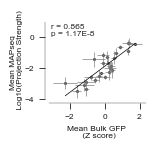

In [22]:
logged_all_cortical = np.log10(mean_all_areas_df.astype(float))
allen_z_normalized = (
    logged_all_cortical.T - logged_all_cortical.mean(axis=1)
) / logged_all_cortical.std(axis=1)
allen_z_normalized = allen_z_normalized.T

mean_series_list = [
    combined_mice_dict[m]["homog_across_cubelet"][columns_to_keep].mean()
    for m in mice
]
mean_all_MAPseq = pd.concat(mean_series_list, axis=1)
mean_all_MAPseq = mean_all_MAPseq * 1e9 #go from um3 to mm3
logged_all_MAPseq = np.log10(mean_all_MAPseq.T)

fig, ax = plt.subplots(figsize=(1.25, 1)) 

plt.errorbar(
    x=allen_z_normalized.mean(),
    y=logged_all_MAPseq.mean(),
    xerr=allen_z_normalized.std(),
    yerr=logged_all_MAPseq.std(),
    fmt="none",
    color="gray",
    alpha=1, linewidth=0.5,
    label=None,
)
# plt.errorbar(x=allen_z_normalized.mean(), y=logged_all_MAPseq.mean(), xerr=allen_z_normalized.std(), yerr=logged_all_MAPseq.std(), fmt='none', color='gray', alpha=0.6, label='Error Bars')
# sb.regplot(x=allen_z_normalized.mean(), y=logged_all_MAPseq.mean(), scatter=False)
scatter = sb.scatterplot(
    x=allen_z_normalized.mean(), y=logged_all_MAPseq.mean(), color="black", alpha=1, s=5,
)
slope, intercept = np.polyfit(
    allen_z_normalized.mean(), logged_all_MAPseq.mean(), 1
)  # 1 makes a linear fit


x_fit = np.linspace(min(allen_z_normalized.mean()), max(allen_z_normalized.mean()), 100)
y_fit = slope * x_fit + intercept

# Plot the best-fit line
plt.plot(x_fit, y_fit, color="black", linewidth=0.5, label="Best Fit Line")
# corr, p = pearsonr(
#     to_plot["Allen_Z_core"], y=to_plot["MAPseq_Z_score"]
# )
corr, p = pearsonr(allen_z_normalized.mean(), logged_all_MAPseq.mean())
# plt.title(
#     f"r = {np.round(corr, 3)}, p = {Decimal(p):.2E}"
# )
x_label = "Mean Bulk GFP \n (Z score)"
y_label ="Mean MAPseq \n Log10(Projection Strength)"
plt.xticks(size=font_size)
plt.yticks(size=font_size)
# handles, labels = scatter.get_legend_handles_labels()
# plt.legend(handles=[handles[1], handles[2]], labels=['Visual cortex areas', 'Other cortical areas'], loc='lower right', fontsize=10)
plt.text(
    0.02,
    0.98,
    f"r = {np.round(corr, 3)} \np = {Decimal(p):.2E}",
    transform=plt.gca().transAxes,
    fontsize=font_size,
    verticalalignment="top",
)
ff.myPlotSettings_splitAxis(fig=fig, ax=ax, ytitle= y_label, xtitle=x_label, title='', mySize =gen_parameters['font_size'])
plt.tick_params(axis='both', which='both',
               bottom=True, top=False, left=True, right=False,
               direction='out', length=4, width=0.6,
               labelsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks(ax.get_yticks()) 
plt.ylim(-4, 1)
fig.savefig(f"{saving_path}/fig_1_mean_allen_vs_area.svg", format="svg")

Make venn diagram of shared barcodes

In [ ]:
from matplotlib_venn import venn3

mice = ["FIAA45.6a", "FIAA45.6d", "FIAA55.4d"]
dfs = {}
for i, mouse in enumerate(mice):
    parameters_path = str(proj_path) + "/" + mouse + "/Sequencing"
    barcodes = pd.read_pickle(f"{parameters_path}/A1_barcodes_thresholded.pkl")
    indices = set(barcodes.index)
    dfs[i] = indices


plt.figure(figsize=(5, 3))
venn = venn3([dfs[0], dfs[1], dfs[2]], (f"{mice[0]}", f"{mice[1]}", f"{mice[2]}"))

colors = ["orchid", "steelblue", "forestgreen"]

alpha_value = 0.8


venn.get_patch_by_id("100").set_facecolor(colors[0])
venn.get_patch_by_id("100").set_alpha(alpha_value)
venn.get_patch_by_id("010").set_facecolor(colors[1])
venn.get_patch_by_id("010").set_alpha(alpha_value)
venn.get_patch_by_id("001").set_facecolor(colors[2])
venn.get_patch_by_id("001").set_alpha(alpha_value)


for patch in venn.patches:
    if patch is not None:
        patch.set_edgecolor("black")
        patch.set_linewidth(2),
        patch.set_linestyle("--")
for label in venn.subset_labels:
    if label is not None:
        label.set_fontsize(14)
        label.set_color("yellow")


plt.show()

Make an overview of projecting only within and outside the auditory cortex and A1

In [5]:
# mice = ["FIAA45.6a", "FIAA45.6d", "FIAA55.4d"]
count_df = pd.DataFrame(
    index=mice,
    columns=[
        "Total",
        "A1 Only",
        "Only Within Auditory Cortex",
        "Out of Auditory Cortex",
    ],
)
combined_dict = {}
for num, mouse in enumerate(mice):
    new_dict = {}
    parameters_path = proj_path / mouse / "Sequencing"
    barcodes = pd.read_pickle(
        parameters_path / "A1_barcodes_thresholded_with_source.pkl"
    )
    bc_no_source = pd.read_pickle(f"{parameters_path}/A1_barcodes_thresholded.pkl")
    bc_no_source = bc_no_source[bc_no_source.sum(axis=1) > 0]
    tot_bc = len(barcodes)
    count_df.loc[mouse, "Total"] = tot_bc
    parameters = fpf.load_parameters(directory=parameters_path)
    lcm_directory = processed_path / (
        "turnerb_" + parameters["lcm_directory"].split("turnerb_")[1]
    )
    sample_vol_path = lcm_directory / "sample_vol_and_regions.pkl"
    sample_vol_and_regions = pd.read_pickle(
        lcm_directory / "sample_vol_and_regions.pkl"
    )
    count_df.loc[mouse, "A1 Only"] = tot_bc - len(bc_no_source)
    any_aud_containing = sample_vol_and_regions[
        (sample_vol_and_regions["main"] == "AUDp")
        | (sample_vol_and_regions["main"] == "AUDv")
        | (sample_vol_and_regions["main"] == "AUDd")
        | (sample_vol_and_regions["main"] == "AUDpo")
    ]
    with_aud = any_aud_containing["ROI Number"].to_list()
    with_aud = [sample for sample in with_aud if sample in barcodes.columns]
    no_A1_mat = barcodes.drop(columns=with_aud)
    no_A1_mat = no_A1_mat[no_A1_mat.sum(axis=1) > 0]
    count_df.loc[mouse, "Only Within Auditory Cortex"] = tot_bc - len(no_A1_mat)
    count_df.loc[mouse, "Out of Auditory Cortex"] = len(no_A1_mat)
    # combined_dict[mouse] = fpf.homog_across_cubelet(parameters_path=parameters_path, barcode_matrix = barcodes, cortical=False, shuffled=False, binary=False, IT_only=False,)

    # common_columns = set(combined_dict['FIAA45.6a'][key].columns).intersection(combined_dict['FIAA45.6d'][key].columns)

In [6]:
# mice = ["FIAA45.6a", "FIAA45.6d", "FIAA55.4d"]
count_df = pd.DataFrame(
    index=mice,
    columns=[
        "Total",
        "A1 Only",
        "Only Within Auditory Cortex",
        "Out of Auditory Cortex",
    ],
)
combined_dict = {}
for num, mouse in enumerate(mice):
    new_dict = {}
    parameters_path = proj_path / mouse / "Sequencing"
    barcodes = pd.read_pickle(
        parameters_path / "A1_barcodes_thresholded_with_source.pkl"
    )
    bc_no_source = pd.read_pickle(parameters_path / "A1_barcodes_thresholded.pkl")
    bc_no_source = bc_no_source[bc_no_source.sum(axis=1) > 0]
    tot_bc = len(barcodes)
    count_df.loc[mouse, "Total"] = tot_bc
    parameters = fpf.load_parameters(directory=parameters_path)
    lcm_directory = processed_path / (
        "turnerb_" + parameters["lcm_directory"].split("turnerb_")[1]
    )
    areas_only_grouped = fpf.get_area_volumes(
        barcode_table_cols=barcodes.columns,
        lcm_directory=lcm_directory,
        area_threshold=0.1,
    )
    A1_only_list = areas_only_grouped[areas_only_grouped["AUDp"] > 0].index.to_list()
    A1_only_list = [sample for sample in A1_only_list if sample in barcodes.columns]
    no_A1_mat = barcodes.drop(columns=A1_only_list)
    no_A1_mat = no_A1_mat[no_A1_mat.sum(axis=1) > 0]
    count_df.loc[mouse, "A1 Only"] = tot_bc - len(no_A1_mat)
    any_aud_containing = sample_vol_and_regions[
        (sample_vol_and_regions["main"] == "AUDp")
        | (sample_vol_and_regions["main"] == "AUDv")
        | (sample_vol_and_regions["main"] == "AUDd")
        | (sample_vol_and_regions["main"] == "AUDpo")
    ]
    with_aud = areas_only_grouped[
        (areas_only_grouped[["AUDp", "AUDv", "AUDd", "AUDpo"]] > 0).any(axis=1)
    ].index.to_list()
    with_aud = [sample for sample in with_aud if sample in barcodes.columns]
    no_AUD_mat = barcodes.drop(columns=with_aud)
    no_AUD_mat = no_AUD_mat[no_AUD_mat.sum(axis=1) > 0]
    count_df.loc[mouse, "Only Within Auditory Cortex"] = tot_bc - len(no_AUD_mat)
    count_df.loc[mouse, "Out of Auditory Cortex"] = len(no_AUD_mat)
    # combined_dict[mouse] = fpf.homog_across_cubelet(parameters_path=parameters_path, barcode_matrix = barcodes, cortical=False, shuffled=False, binary=False, IT_only=False,)

    # common_columns = set(combined_dict['FIAA45.6a'][key].columns).intersection(combined_dict['FIAA45.6d'][key].columns)

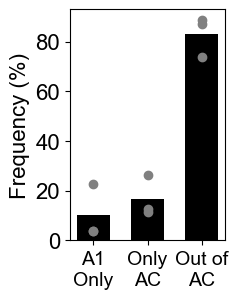

In [5]:
# freq_columns = ["A1 Only", "Only Within Auditory Cortex", "Out of Auditory Cortex"]
# frequencies = count_df[freq_columns].div(count_df["Total"], axis=0) * 100

# mean_frequencies = frequencies.mean()
# fig, ax = plt.subplots(figsize=(2, 3))
# x = np.arange(len(freq_columns))
# bar_width = 0.6
# ax.bar(
#     x,
#     mean_frequencies,
#     width=bar_width,
#     label="Mean Frequency",
#     color="black",
#     zorder=1,
# )
# for i, column in enumerate(freq_columns):
#     y = frequencies[column]
#     ax.scatter(
#         [x[i]] * len(y),
#         y,
#         label=f"{column} Replicates" if i == 0 else "",
#         color="grey",
#         zorder=2,
#     )

# wrapped_labels = ["A1\nOnly", "Only\nAC", "Out of\nAC"]
# ax.set_xticks(x)
# ax.set_xticklabels(wrapped_labels, fontsize=14)

# ax.set_ylabel("Frequency (%)", fontsize=16)
# plt.yticks(size=16)

# plt.show()

In [7]:
freq_columns = ["A1 Only", "Only Within Auditory Cortex", "Out of Auditory Cortex"]
frequencies = count_df[freq_columns].div(count_df["Total"], axis=0)
mean_frequencies = frequencies.mean()
frequencies.drop(columns=["A1 Only"], inplace=True)

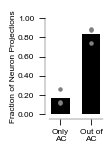

In [8]:
freq_columns = ["Only Within Auditory Cortex", "Out of Auditory Cortex"]
mean_frequencies = frequencies.mean()

fig, ax = plt.subplots(figsize=(0.7, 1.25))
x = np.arange(len(freq_columns))
bar_width = 0.6
ax.bar(
    x,
    mean_frequencies,
    width=bar_width,
    label="Mean Frequency",
    color="black",
    zorder=1,
)

for i, column in enumerate(freq_columns):
    y = frequencies[column]
    ax.scatter(
        [x[i]] * len(y),
        y,
        label=f"{column} Replicates" if i == 0 else "",
        color="grey",
        zorder=2, s=5,
        edgecolor="grey",
    )

wrapped_labels = ["Only\nAC", "Out of\nAC"]
ax.set_xticks(x)
ax.set_xticklabels(wrapped_labels, fontsize=font_size)

y_label= "Fraction of Neuron Projections"
plt.yticks(size=font_size)
ff.myPlotSettings_splitAxis(fig=fig, ax=ax, ytitle=y_label, xtitle='', title='', mySize=font_size)
ax.tick_params(axis='both', which='both',
               bottom=True, top=False, left=True, right=False,
               direction='out', length=4, width=0.6,
               labelsize=font_size)
ax.set_xticklabels(wrapped_labels, fontsize=font_size)
ax.set_yticks(ax.get_yticks()) 
ax.set_yticklabels([f"{tick:.2f}" for tick in ax.get_yticks()], fontsize=font_size)

fig.savefig(f"{saving_path}/fig_1_within_vs_outside_AC.svg", format="svg")
plt.show()

Now lets look at frequency across areas

In [9]:
# mice = ["FIAA45.6a", "FIAA45.6d", "FIAA55.4d"]
count_df = pd.DataFrame(
    index=mice,
    columns=[
        "Total",
        "A1 Only",
        "Only Within Auditory Cortex",
        "Out of Auditory Cortex",
    ],
)
combined_dict = {}
for num, mouse in enumerate(mice):
    new_dict = {}
    parameters_path = proj_path / mouse / "Sequencing"
    barcodes = pd.read_pickle(parameters_path / "A1_barcodes_thresholded.pkl")
    combined_dict[mouse] = fpf.homog_across_cubelet(
        parameters_path=parameters_path,
        barcode_matrix=barcodes,
        binary=False,
        cortical=True,
        IT_only=True,
        shuffled=False,
    )

In [10]:
mcc = MouseConnectivityCache()
structure_tree = mcc.get_structure_tree()
common_columns_cubelet = set(combined_dict[mice[0]].columns)
for mouse in mice[1:]:
    common_columns_cubelet = common_columns_cubelet.intersection(
        combined_dict[mouse].columns
    )

common_columns_cubelet = list(common_columns_cubelet)
common_cols_cortex = []
for col in common_columns_cubelet:
    if col not in ["Contra", "OB"]:
        structure = structure_tree.get_structures_by_acronym([col])
        if 315 in structure[0]["structure_id_path"]:
            common_cols_cortex.append(col)
matrix = pd.concat(
    [combined_dict[mouse][common_cols_cortex] for mouse in mice],
    ignore_index=True,
)
convert_dict = ff.get_convert_dict()

In [37]:
# convert_dict = {
#     "VISp": "V1",
#     "VISpor": "POR",
#     "VISli": "LI",
#     "VISal": "AL",
#     "VISl": "LM",
#     "VISpl": "P",
#     "VISpm": "PM",
#     "VISrl": "RL",
#     "VISam": "AM",
#     "VISa": "A",
# }

In [19]:
# area_groups = {
#     "AUDITORY CORTEX": ["AUDd", "AUDv", "AUDpo"],
#     "LATERAL CORTEX": ["TEa", "PERI", "ECT"],
#     "VISUAL CORTEX": [
#         "VISal",
#         "VISp",
#         "VISpl",
#         "VISpm",
#         "VISrl",
#         "VISpor",
#         "VISam",
#         "VISl",
#         "VISa",
#         "VISli",
#     ],
#     "SOMATOMOTOR CORTICAL AREAS": ["MOp", "MOs", "SSp", "SSs"],
#     "CINGULATE CORTEX": ["RSPv", "RSPd", "RSPagl", "ACAd", "ACAv"],
# }
# freq_df = pd.DataFrame(index=mice, columns=common_cols_cortex)
# tot_freq = pd.DataFrame(index=mice, columns=area_groups.keys())
# for mouse in mice:
#     df_to_look = combined_dict[mouse].astype(bool).astype(int)
#     for area in common_cols_cortex:
#         freq_df.loc[mouse, area] = df_to_look[area].mean()
#     for grouped_area in tot_freq.columns:
#         frequency = len(
#             df_to_look[df_to_look[area_groups[grouped_area]].sum(axis=1) > 0]
#         ) / len(df_to_look)
#         tot_freq.loc[mouse, grouped_area] = frequency

# plot_data = []
# group_positions = []
# x_labels = []  #

# x_pos = 0

# for group, columns in area_groups.items():
#     sorted_columns = sorted(columns, key=lambda col: freq_df[col].mean(), reverse=True)
#     group_mean = tot_freq[group]
#     plot_data.append(group_mean)
#     x_labels.append(f"Total")
#     group_positions.append(x_pos - 0.5)
#     x_pos += 1
#     group_positions.append(x_pos - 0.5)

#     for area in sorted_columns:
#         plot_data.append(freq_df[area])
#         x_labels.append(area)
#         x_pos += 1

# x_labels = [
#     item if item not in convert_dict.keys() else convert_dict[item] for item in x_labels
# ]
# plot_df = pd.concat(plot_data, axis=1).T
# plot_df.columns = freq_df.index
# plot_df.index = x_labels

# fig, ax = plt.subplots(figsize=(12, 3))

# for i, (label, row) in enumerate(plot_df.iterrows()):
#     ax.scatter(
#         [i] * len(row),
#         row,
#         color="grey",
#         edgecolor="black",
#         zorder=2,
#         label="Individual Points" if i == 0 else "",
#     )
#     ax.bar(
#         i,
#         row.mean(),
#         color="black",
#         edgecolor="black",
#         zorder=1,
#         width=0.5,
#         label="Mean" if i == 0 else "",
#     )
# # for pos in group_positions:
# #     ax.axvline(x=pos, color="k", linestyle="--", linewidth=1, zorder=0)

# ax.set_xticks(range(len(plot_df.index)))
# ax.set_xticklabels(plot_df.index, rotation=90, ha="right", fontsize=font_size)
# ax.set_ylabel("Frequency", fontsize=font_size)
# ax.tick_params(axis="y", labelsize=font_size, length=4, width=0.5)
# ax.margins(x=0)               # kill the default 5 % padding
# ax.set_xlim(-0.5, len(plot_df.index)-0.5) 
# plt.tight_layout()
# plt.show()

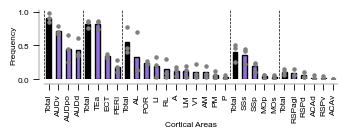

In [11]:
area_groups = {
    "AUDITORY CORTEX": ["AUDd", "AUDv", "AUDpo"],
    "LATERAL CORTEX": ["TEa", "PERI", "ECT"],
    "VISUAL CORTEX": [
        "VISal",
        "VISp",
        "VISpl",
        "VISpm",
        "VISrl",
        "VISpor",
        "VISam",
        "VISl",
        "VISa",
        "VISli",
    ],
    "SOMATOMOTOR CORTICAL AREAS": ["MOp", "MOs", "SSp", "SSs"],
    "CINGULATE CORTEX": ["RSPv", "RSPd", "RSPagl", "ACAd", "ACAv"],
}
freq_df = pd.DataFrame(index=mice, columns=common_cols_cortex)
tot_freq = pd.DataFrame(index=mice, columns=area_groups.keys())
for mouse in mice:
    df_to_look = combined_dict[mouse].astype(bool).astype(int)
    for area in common_cols_cortex:
        freq_df.loc[mouse, area] = df_to_look[area].mean()
    for grouped_area in tot_freq.columns:
        frequency = len(
            df_to_look[df_to_look[area_groups[grouped_area]].sum(axis=1) > 0]
        ) / len(df_to_look)
        tot_freq.loc[mouse, grouped_area] = frequency

plot_data = []
group_positions = []
x_labels = [] 
x_pos = 0
for group, columns in area_groups.items():
    sorted_columns = sorted(columns, key=lambda col: freq_df[col].mean(), reverse=True)
    group_mean = tot_freq[group]
    plot_data.append(group_mean)
    x_labels.append(f"Total")
    group_positions.append(x_pos - 0.5)
    x_pos += 1
    group_positions.append(x_pos - 0.5)

    for area in sorted_columns:
        plot_data.append(freq_df[area])
        x_labels.append(area)
        x_pos += 1

x_labels = [
    item if item not in convert_dict.keys() else convert_dict[item] for item in x_labels
]
plot_df = pd.concat(plot_data, axis=1).T
plot_df.columns = freq_df.index
plot_df.index = x_labels
fig, ax = plt.subplots(figsize=(3.8, 0.9))

for i, (label, row) in enumerate(plot_df.iterrows()):
    is_total = label == "Total" or label.startswith("Total")  # catch renamed totals too
    bar_color = "black" if is_total else "mediumpurple"

    ax.scatter(
        [i] * len(row),
        row,
        color="grey",
        edgecolor="grey", s=5,
        zorder=2,
        label="Individual Points" if i == 0 else "",
    )
    ax.bar(
        i,
        row.mean(),
        color=bar_color,
        edgecolor="black",
        zorder=1,
        width=0.5,
        label="Mean" if i == 0 else "",
    )
ax.set_xticks(range(len(plot_df.index)))

ax.tick_params(axis="y", labelsize=font_size, length=4, width=0.5)

ff.myPlotSettings_splitAxis(fig=fig, ax=ax, ytitle='Frequency', xtitle='Cortical Areas', title='', mySize=font_size)

total_indices = [i for i, label in enumerate(plot_df.index) if label == "Total" or label.startswith("Total")]

for idx in total_indices:
    ax.axvline(x=idx - 0.5, color="k", linestyle="--", linewidth=0.5, zorder=0)

ax.axvline(x=len(plot_df.index) - 0.5, color="k", linestyle="--", linewidth=0.5, zorder=0)

ax.tick_params(axis='both', which='both',
               bottom=True, top=False, left=True, right=False,
               direction='out', length=4, width=0.6,
               labelsize=font_size)
ax.set_xticklabels(plot_df.index, rotation=90, ha="center", fontsize=font_size)
# ax.set_yticks(ax.get_yticks()) 
# ax.set_yticklabels([f"{tick:.2f}" for tick in ax.get_yticks()], fontsize=font_size)
#ax.set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0],fontsize=font_size)
ax.margins(x=0)               # kill the default 5 % padding
ax.set_xlim(-0.5, len(plot_df.index)-0.5) 
ax.xaxis.set_label_coords(0.5, -0.6)
fig.savefig(f"{saving_path}/fig_1_mean_freq_cortical_proj.svg", format="svg")
plt.show()
